In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [4]:
# 1. Generate 50 points using uniform distribution
# In the range 0 to 1
# 3x50 is preferable over 50x3
N = 50
p = np.random.uniform(0, 1, (3, N))

p.shape

(3, 50)

In [7]:
# 2. move 3D object away from the camera with some random vector
# Add [ 1 4 3] to all the points - 1 to x, 4 to y and 3 to z.
offset = np.repeat([[1], [4], [3]], N, axis=1)
p = p + offset
p.shape

(3, 50)

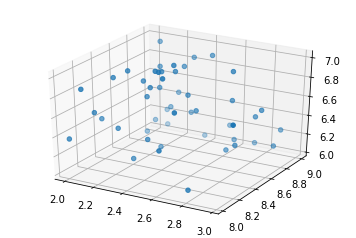

In [14]:
# Visualize 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[0,:], p[1,:], p[2,:], zdir='z', s=20, c=None, depthshade=True)
plt.interactive(False)
plt.show()

In [16]:
# We need to put the homogenous component “1” at the end of each 3d vector.
# Final matrix will be of size 4xN.
v_ones = np.ones((1, N))
p = np.vstack((p, v_ones))
p.shape

(4, 50)

In [20]:
# 3. Project the points into two cameras using the two projection matrices.
# First Camera = C1
# C1 = [ [1 0 0 0], [0 1 0 0], [0 0 1 0]]
# i.e. C1 = [I, 0] => 3x4
C1 = np.hstack((np.eye(3), np.zeros((3,1))))
C1.shape

(3, 4)

In [23]:
# Second camera at (R, t)
# R is pi/6 rotation (x,y)
R = np.array([
    [0.8660, 0.2500, 0.4330],
    [0, 0.8660, -0.5000],
    [-0.5000, 0.4330, 0.7500]
])
t = np.array([
    [-0.4, 0.3, 0.6]
])

t = t.T
print(R.shape, t.shape)

C2 = np.hstack((R,t))
C2.shape

(3, 3) (3, 1)


(3, 4)

In [30]:
# Projection with first (P1) and second camera (P2)
# For each point,
# P1 = C1 * p (dot product)
# P2 = C2 * p (dot product)
# output is w*[u, v, 1] 
# => ok for epipolar equation, 
# but not ok for actual camera projections
P1 = np.dot(C1, p)
P2 = np.dot(C2, p)

P1.shape, P2.shape

((3, 50), (3, 50))

In [32]:
# to visualize image projections we need [u,v,1], 
# therefore divide by last homogeneous element
u1 = P1[0,:] / P1[2,:]
v1 = P1[1,:] / P1[2,:]

u2 = P2[0,:] / P2[2,:]
v2 = P2[1,:] / P2[2,:]

In [35]:
# 4. Form the epipolar equations
# Use corresponding points in the image to generate 8 point equations
# A = [u2 * u1, u2 * v1 , u2 , v2 * u1 , v2 * v1 , v2 , u1 , v1 , 1]
A = np.vstack((
    u2 * u1,
    u2 * v1,
    u2,
    v2 * u1,
    v2 * v1,
    v2,
    u1,
    v1,
    np.ones((1, N))
))
A = A.T
A.shape

(50, 9)

In [39]:
# 5. Formulate two equations:
# Solve Ax = 0
# F = vh[
# Ax = 0 and
# Ax = b
# 6. Solve using svd and pseudoinverse
# A * f = 0, ||f||=1

u_svd, s_svd, vh_svd = np.linalg.svd(A, full_matrices=False)

# Note python gives vh_svd.T instead of vh_svd
# A = u*s*vh in python instead of u*s*vh.T

s_svd = np.diag(s_svd)
Ah = np.dot(np.dot(u_svd, s_svd), vh_svd)
print(np.linalg.norm((A - Ah)))

7.748927244085305e-15


In [40]:
# get solution: last row of vh
f = vh_svd[-1,:]
f

array([-0.13580598, -0.35282394,  0.47532094,  0.28935728,  0.29261662,
        0.50682793, -0.23521596, -0.38152427,  0.06346666])

In [41]:
# get the Essential matrix (E)
E = f.reshape((3,3))
E

array([[-0.13580598, -0.35282394,  0.47532094],
       [ 0.28935728,  0.29261662,  0.50682793],
       [-0.23521596, -0.38152427,  0.06346666]])

In [44]:
# The actual Essential matrix is:
tx = np.array([
    [0, -t[2], t[1]],
    [t[2], 0, -t[0]],
    [-t[1], t[0], 0]
])
E_actual = np.dot(tx, R)
E_actual

array([[-0.15  , -0.3897,  0.525 ],
       [ 0.3196,  0.3232,  0.5598],
       [-0.2598, -0.4214,  0.0701]])

In [45]:
# scale is not relevant since if E satisfies epipolar equation,
#  w*E also does.
E_actual = E_actual / np.linalg.norm(E_actual)
E_actual

array([[-0.13580598, -0.35282394,  0.47532094],
       [ 0.28935728,  0.29261662,  0.50682793],
       [-0.23521596, -0.38152427,  0.06346666]])